In [1]:
%env CUDA_VISIBLE_DEVICES=MIG-768d9c1d-110f-52e2-b0a2-3252f78280f8

env: CUDA_VISIBLE_DEVICES=MIG-768d9c1d-110f-52e2-b0a2-3252f78280f8


In [2]:
import io
import torch
import torch.nn as nn
import PIL.Image
import einops
import matplotlib.pyplot as plt
import numpy as np
import datasets
import math
import torchaudio
import random
from itertools import combinations
from IPython.display import HTML, Audio
from types import SimpleNamespace
from timm.optim import Mars
from fastprogress import progress_bar, master_bar
from torchvision.transforms.v2 import CenterCrop, RandomCrop, Resize
from torchvision.transforms.v2.functional import to_pil_image, pil_to_tensor
from autocodec.codec import AutoCodecND, latent_to_pil, pil_to_latent

In [3]:
device="cuda"
dataset = datasets.load_dataset("danjacobellis/aria_ea_audio_preprocessed")

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

In [4]:
config = SimpleNamespace()
config.F = 128
config.latent_dim = 28;
config.input_channels = 7
config.encoder_depth = 4
config.encoder_kernel_size = 1
config.decoder_depth = 8
config.lightweight_encode = True
config.lightweight_decode = False
config.freeze_encoder_after = 0.7
config.λ = 3e-2
config.lr_pow = 6
config.batch_size = 2
config.max_lr = (64/config.batch_size)*1e-3
config.min_lr = config.max_lr / 1e3
config.num_workers = 32
config.epochs = 200
config.progressive_sizes = [config.F*int(s) for s in 2**(np.linspace(10,11.1945,config.epochs))]; 
config.total_steps = config.epochs * (dataset['train'].num_rows // config.batch_size)
config.checkpoint = False
print(config.progressive_sizes[0],config.progressive_sizes[-1])

131072 299904


In [5]:
model = AutoCodecND(
    dim=1,
    input_channels=config.input_channels,
    J = int(np.log2(config.F)),
    latent_dim=config.latent_dim,
    encoder_depth = config.encoder_depth,
    encoder_kernel_size = config.encoder_kernel_size,
    decoder_depth = config.decoder_depth,
    lightweight_encode = config.lightweight_encode,
    lightweight_decode = config.lightweight_decode,
).to(device)

if config.checkpoint:
    checkpoint = torch.load(config.checkpoint,weights_only=False)
    model.load_state_dict(checkpoint['state_dict'])

print(f"{sum(p.numel() for p in model.parameters())/1e6} M parameters")

optimizer = Mars(model.parameters(), lr=1.0, caution=True)

def rc_sched(i_step, config):
    t = i_step / config.total_steps
    return (config.max_lr - config.min_lr) * (1 - ((np.cos(np.pi*t))**(2*config.lr_pow))) + config.min_lr

schedule = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda i_step: rc_sched(i_step, config)
)

103.802412 M parameters


In [6]:
def get_epoch_size(epoch):
    idx = min(epoch, len(config.progressive_sizes)-1)
    return config.progressive_sizes[idx]
    
def collate_fn(batch,epoch):
    L = get_epoch_size(epoch)
    C = config.input_channels
    x = []
    for sample in batch:
        x.append(RandomCrop((C,L))(torch.tensor(sample['audio']).permute(1,0)).unsqueeze(0))
    return torch.cat(x).to(torch.float32)

In [ ]:
learning_rates = [optimizer.param_groups[0]['lr']]
mb = master_bar(range(config.epochs))
losses = []
rate_losses = []

global_step = 0
model.train()
for i_epoch in mb:
    #-----Train-----
    model.train()
    dataloader_train = torch.utils.data.DataLoader(
            dataset['train'],
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            drop_last=True,
            shuffle=True,
            collate_fn=lambda batch: collate_fn(batch, i_epoch)
        )
    pb = progress_bar(dataloader_train, parent=mb)
    for i_batch, x in enumerate(pb):
        x = x.to(device)
        if i_epoch/config.epochs <= config.freeze_encoder_after :
            # Soft quantization with additive noise
            x_hat, rate = model(x)
        else:
            # Hard quantization
            with torch.no_grad():
                z = model.quantize.compand(model.encode(x))
                z_quant = z.round()
            rate = z.std().log2()              
            x_hat = model.decode(z_quant)

        # Loss and optimizer
        mse_loss = torch.nn.functional.mse_loss(x, x_hat).log10()
        losses.append(mse_loss.item())
        rate_losses.append(rate.item())
        total_loss = mse_loss + config.λ * rate
        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        schedule.step()
        learning_rates.append(optimizer.param_groups[0]['lr'])
        pb.comment = (f"PSNR: {-10*losses[-1]+6.02:.3g}, R: {rate:.2g}, LR: {learning_rates[-1]:.2g}")
        global_step += 1

    torch.save({
        'i_epoch': i_epoch,
        'losses': losses,
        'rate_losses': rate_losses,
        'config': config,
        'state_dict': model.state_dict()
    }, f'checkpoint_f{config.F}c{config.latent_dim}.pth')

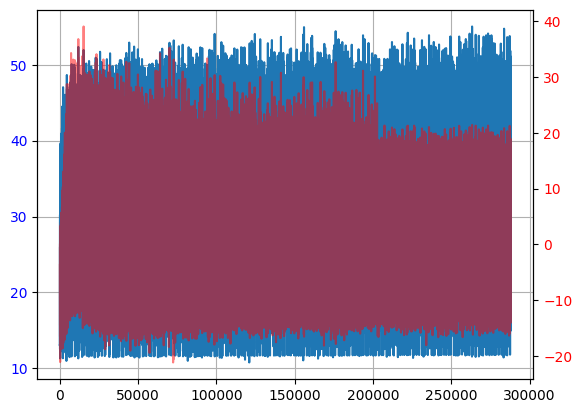

In [8]:
display(HTML(mb.main_bar.progress))
display(HTML(pb.progress))
fig, ax1 = plt.subplots()
ax1.plot(-10*np.array(losses)+6.02)
ax1.grid(True)
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(-10*np.array(rate_losses), color='red', alpha=0.5)
ax2.tick_params(axis='y', labelcolor='red')
plt.show()

In [9]:
torch.save({
    'config': config,
    'state_dict': model.state_dict()
}, '../../hf/autocodec/aria_7ch_f128c28.pth')

In [38]:
x = collate_fn(dataset['validation'].select(range(2)),config.epochs)
x = CenterCrop((7,303104))(x)

In [40]:
Audio(x[0][:2], rate=44100)

In [41]:
model.eval()
with torch.no_grad():
    z = model.quantize.compand(model.encode(x.to(device))).round()
    xhat = model.decode(z).clamp(-1,1).to("cpu")

In [42]:
Audio(xhat[0][:2], rate=44100)

In [75]:
-10*torch.nn.functional.mse_loss(x,xhat).log10().item() + 6.02

26.470763702392578

In [76]:
z_reshaped = einops.rearrange(z.cpu(), 'b c (h w) -> (b c) h w', h=64).unsqueeze(1)
img_list = latent_to_pil(z_reshaped, n_bits=8, C=1)
buff = []
for img in img_list:
    buff.append(io.BytesIO())
    latent_img[0].save(buff[-1], format='TIFF', compression='tiff_adobe_deflate')
cr = 2*x.numel() / sum(len(b.getbuffer()) for b in buff)
cr

140.58627087198516

(-4.0, 4.0)

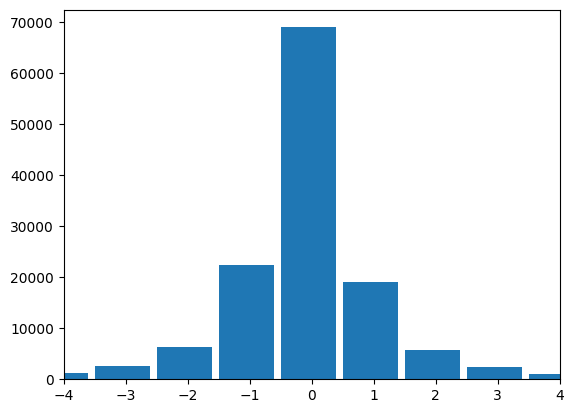

In [77]:
plt.hist(z.flatten().cpu().numpy(),range=(-127.5,127.5),bins=255,width=0.9);
plt.xlim([-4,4])